In [1]:
import os
import ants
import numpy as np
import pandas as pd
from tqdm import tqdm
from sade.configs.ve import biggan_config
from sade.datasets.loaders import get_val_transform
from sade.metrics import erode_brain_masks

basedir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/experiments/default-ckpt-150/ibis-ds-sa/"
transforms_dir = f"/DATA/Users/amahmood/braintyp/spacing_2/"
template_dir = "/codespace/braintypicality/dataset/template_cache/"

config = biggan_config.get_config()
img_loader = get_val_transform(config)
procd_ref_img_path = f"{template_dir}/cropped_niral_mni.nii.gz"
ref_img_tensor = img_loader({"image": procd_ref_img_path})["image"].numpy()
ref_img_post_transform = (ants.from_numpy(ref_img_tensor[0]) + 1) / 2
mni_brain_mask = ref_img_post_transform.get_mask()

def register_to_mni(x:np.ndarray, sampleid: str):
    x = ants.from_numpy(x)
    transform_mat = f"{transforms_dir}/{sampleid}Composite.h5"
    return ants.apply_transforms(
        fixed=ref_img_post_transform, interpolator="linear", verbose=False,
        moving=x, transformlist=transform_mat
    ).numpy()

2024-12-16 22:36:34.803570: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 22:36:34.814225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-16 22:36:34.827289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-16 22:36:34.831239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 22:36:34.841341: I tensorflow/core/platform/cpu_feature_guar

In [2]:
ds_protoypes = pd.read_csv("data/ds_prototypes_11x11.csv")
largest_prototype_bmu_idx = ds_protoypes.groupby('bmu').count().idxmax()[0]
ds_max_prototype_ids = ds_protoypes[ds_protoypes.bmu == largest_prototype_bmu_idx]['ID']
ds_max_prototype_ids

0     IBIS105477
1     IBIS110925
3     IBIS146443
4     IBIS241887
5     IBIS270140
10    IBIS509327
11    IBIS514978
12    IBIS546895
14    IBIS615948
15    IBIS688878
17    IBIS718082
18    IBIS734750
19    IBIS767531
20    IBIS782429
22    IBIS828516
27    IBIS984945
Name: ID, dtype: object

In [3]:
heatmaps = []
for sid in tqdm(ds_max_prototype_ids):
    fname = f"{basedir}/{sid}.npz"
    h = np.load(fname)['heatmap']
    h_aligned = register_to_mni(h, sid)
    heatmaps.append(h_aligned)

100%|██████████| 16/16 [00:01<00:00,  8.91it/s]


In [4]:
protoavg = np.median(heatmaps, axis=0)
protoavg.shape

(96, 112, 80)

In [5]:
protoavg_img = ants.from_numpy(protoavg)
protoavg_img.to_file('/ASD/ahsan_projects/Developer/ds-analysis/lowres-dsproto-median.nii.gz')

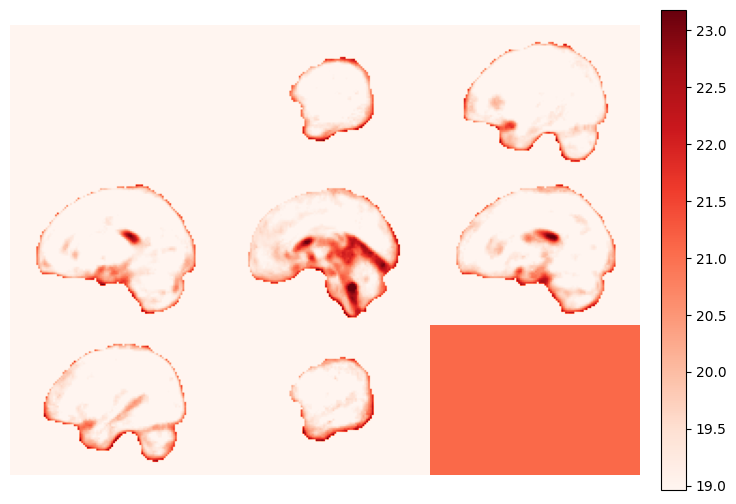

In [6]:
eroded_brain_mask = erode_brain_masks(mni_brain_mask.numpy()[None,...], radius=2.75)[0]
x = protoavg - protoavg.min()
x = x * eroded_brain_mask
qmin, qmax = np.quantile(x[x>0], 0.5), np.quantile(x[x>0], 0.999)
x[x<qmin] = qmin
x[x>qmax] = qmax
img = ants.from_numpy(x)
img.plot(nslices=9, cmap="Reds", cbar=True)

In [7]:
eroded_brain_mask = erode_brain_masks(mni_brain_mask.numpy()[None,...], radius=2.25)[0]
mni_eroded = ref_img_post_transform * ants.from_numpy(eroded_brain_mask)
mni_eroded

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [8]:
ants.plot(mni_eroded, overlay=img,
          nslices=18, ncol=6, scale=False, #scale=(0.01, 0.999),
          overlay_cmap="magma", overlay_alpha=0.75,
          cbar=False, cbar_vertical=False, filename='figures/voxel-saggital.pdf')

In [9]:
ants.plot(mni_eroded, overlay=img, axis=1,
          nslices=18, ncol=6, scale=False,
          overlay_cmap="magma", overlay_alpha=0.75,
          cbar=False, cbar_vertical=False,  filename='figures/voxel-coronal.pdf')

In [10]:
ants.plot(mni_eroded, overlay=img, axis=2,
          nslices=18, ncol=6, scale=False,
          overlay_cmap="magma", overlay_alpha=0.75,
          cbar=False, cbar_vertical=False,  filename='figures/voxel-axial.pdf')

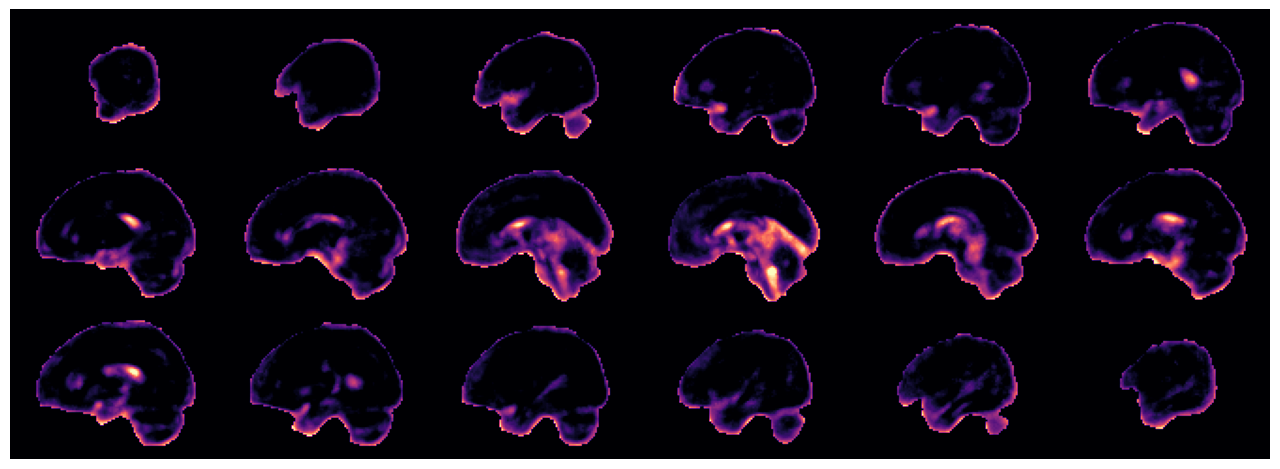

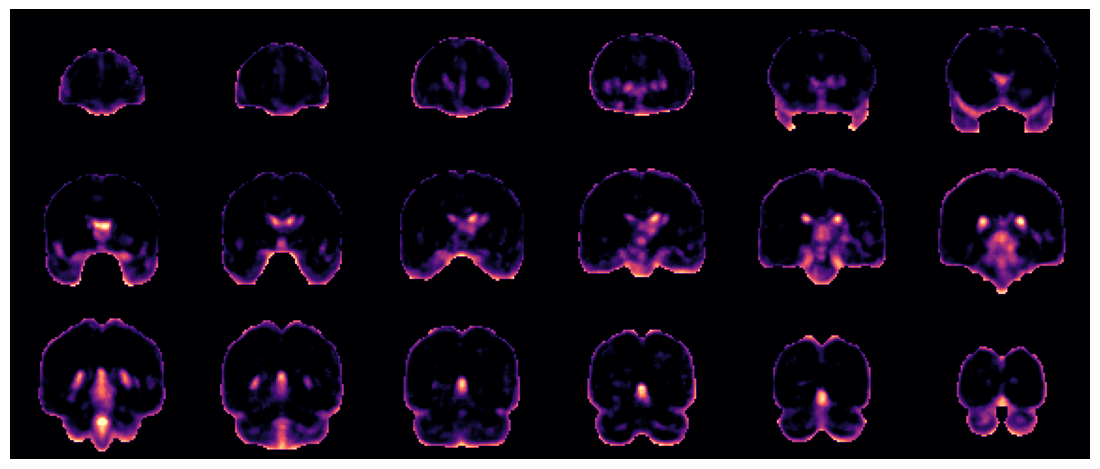

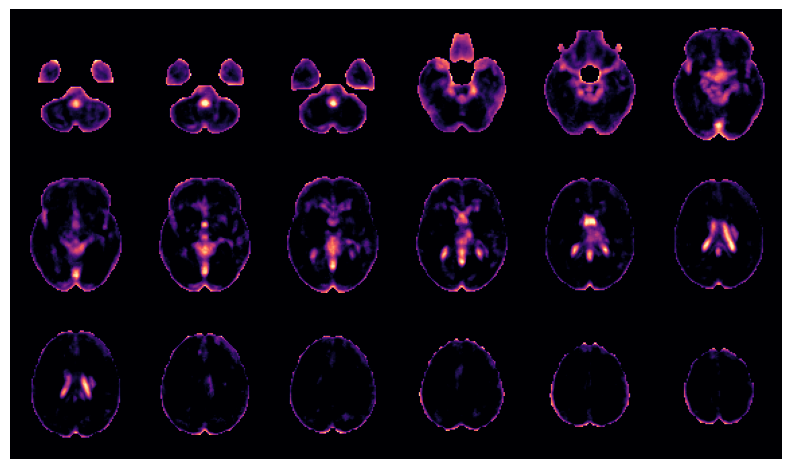

In [11]:
ants.plot(img, slices=np.linspace(0.2,0.8,18), cmap="magma", cbar=False,
          cbar_vertical=False, scale=False, ncol=6)

ants.plot(img, slices=np.linspace(0.2,0.8,18), cmap="magma", cbar=False,
          cbar_vertical=False, scale=False, ncol=6, axis=1)

ants.plot(img, slices=np.linspace(0.2,0.8,18), cmap="magma", cbar=False,
          cbar_vertical=False, scale=False, ncol=6, axis=2)